<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 10: Regression Splines</h2></center>
<br>

In this tutorial we study how to implement regression splines and generalised additive models in Python.

<a class="buttom" href="#Data:-Customer-Analytics">Data: Customer Analytics</a> <br>
<a class="buttom" href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a class="buttom" href="#Regression-Splines">Regression Splines</a> <br>
<a class="buttom" href="#Natural-Splines">Natural Splines</a> <br>
<a class="buttom" href="#Generalised-Additive-Model">Generalised Additive Model</a> <br>
<a class="buttom" href="#Model-Evaluation">Model Evaluation</a> <br>
<a class="buttom" href="#Exercise">Exercise</a> <br>

This notebook relies on the following imports and settings.

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Rigure settings
sns.set_context('notebook') 
sns.set_style('ticks')
blue='#1F77B4'
%matplotlib inline

## Data: Customer Analytics

We again focus on the customer acquisition and profitability dataset from Tutorial 9.

In [3]:
data = pd.read_excel('Datasets/CustomerAcquisition.xls', index_col=[0])
data.head(10)

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.0000,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.0000,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.0000,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.7316,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.0000,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49
6,0,0.00,0.0000,0,0,435.57,189721.22,0,22.54,359,0.00,0.00,0,0,0
7,0,0.00,0.0000,0,0,362.90,131696.41,0,32.97,902,0.00,0.00,0,0,0
8,0,0.00,0.0000,0,0,883.54,780642.93,0,22.48,264,0.00,0.00,0,0,0
9,1,599.30,6.9161,730,1,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,1,11,121


The objective of this type of analysis is to predict the profitability of a customer, which involves both classification and regression tasks. We apply classification methods to predict whether a customer will be acquired (Tutorial 9) and retained, and we apply regression methods to estimate the profitability of acquired and retained customers to the company.

Here, we focus on the latter task (regression), though a more complete model can include all parts of the customer cycle. In particular, we will model the customer lifetime value (CLV) taking into account nonlinearities present in the data.

The response variable, thus, is the customer lifetime value (CLV, a measure of profitability) of customers who were acquired and remained as customers by the end of the observation window (730 days). These customers are identified with a value of one for the <TT>Censor</TT> variable.

In [4]:
data = data[data['Censor']==1] # our goal is to predict the CLV of retained customers, identified by Censor=1 

The predictors are dollars spent on marketing expenses for acquiring and retaining the customer, the value of the first purchase, revenue and number of employees of the customer, the number of product categories the customer purchased, the number of times the customer purchased during the observation window, and industry.

In [5]:
response = ['CLV']
predictors=['Acq_Expense', 'Ret_Expense', 'First_Purchase', 'Revenue', 'Employees', 'Crossbuy', 'Frequency', 'Industry']
    
data = data[response+predictors] # keeping only the variables that we are going to use

As usual, we split the data into training (70%) and test (30%) sets before proceeding. 

In [6]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

X_train = train[predictors]
X_test = test[predictors]
y_train= train['CLV']
y_test= test['CLV']

## Exploratory Data Analysis

We start by computing the correlations between the response and the predictors as a reference for our analysis.

In [7]:
train.corr().round(3)[['CLV']]

,CLV
CLV,1.000
Acq_Expense,-0.373
Ret_Expense,0.455
First_Purchase,0.581
Revenue,0.085
Employees,0.530
Crossbuy,0.413
Frequency,-0.067
Industry,0.209


To explore possible nonlinearities in the data, we build scatter plots for all the numerical predictors. The scatter plots include local regression fits for visualisation. Nonlinear patters are apparent for several predictors, in particular the acquisition and retention expenses, customer revenue, and purchasing frequency. 

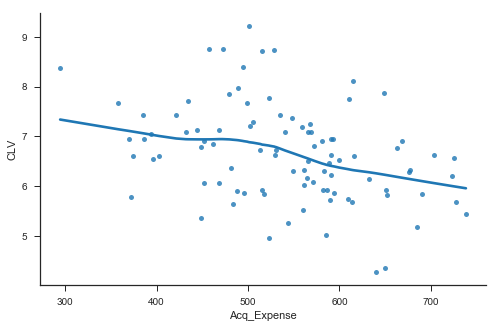

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Acq_Expense'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

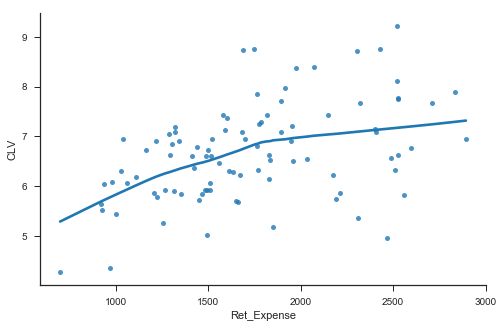

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Ret_Expense'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

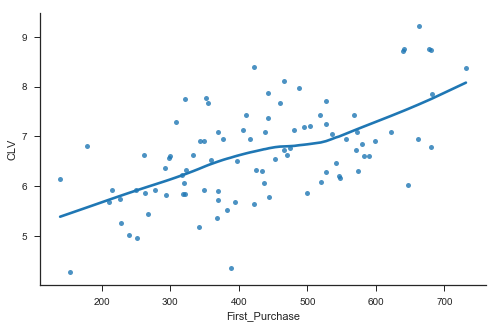

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['First_Purchase'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

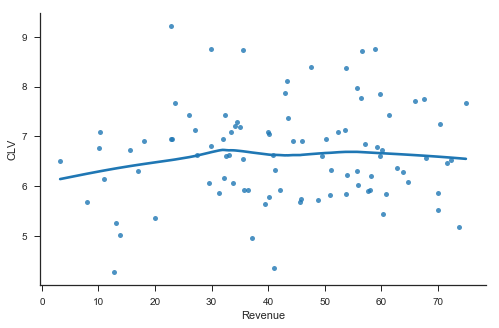

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Revenue'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

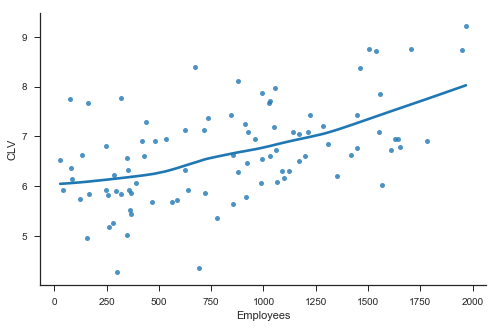

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Employees'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

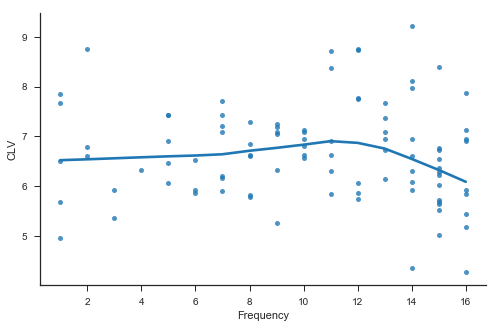

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Frequency'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

## Regression Splines

We use the [<TT>patsy</TT>](http://patsy.readthedocs.io/en/latest/index.html) library to construct spline expansions. Our implementation is based on two core functions: [<TT>dmatrix</TT>](http://patsy.readthedocs.io/en/latest/API-reference.html#patsy.dmatrix), the general design matrix constructor, and [<TT>bs</TT>](http://patsy.readthedocs.io/en/latest/API-reference.html#spline-regression), the building block for regression splines.

The next cell builds cubic spline basis functions and evaluates then at the training data values of the retaining expense predictor.   We specify that we want the cubic spline by setting degree=3. We remove the column of ones from the design matrix because the intercept will be added in at the linear regression fitting stage.  We set the degrees of freedom as df=4, which has the effect of setting the number of knots to 1 (recall from the lecture that when the intercept is included, df are given by the number of knots plus 4, but we removed the intercept, so our df = number of knots + 3).

The function below generates so-called B-splines rather than the exact spline functions defined in the lecture. B-splines generate an equivalent model, but lead to more numerically stable computations. 

In [14]:
from patsy import dmatrix

X = dmatrix('bs(predictor, degree=3, df=4) - 1', {'predictor': train['Ret_Expense']}, return_type='dataframe')
# The -1 excludes the intercept
X.head()

,"bs(predictor, degree=3, df=4)[0]","bs(predictor, degree=3, df=4)[1]","bs(predictor, degree=3, df=4)[2]","bs(predictor, degree=3, df=4)[3]"
Customer,,,,
350,0.606539,0.280049,0.037076,0.000000
317,0.237217,0.496742,0.265357,0.000684
337,0.140893,0.452204,0.394179,0.012725
467,0.033173,0.250264,0.570477,0.146086
184,0.008891,0.122594,0.533078,0.335436


Given the design matrix, we estimate the model by OLS. 

In [15]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(X, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
from patsy import build_design_matrices

a=train['Ret_Expense'].min()
b=train['Ret_Expense'].max()
x=np.linspace(a, b)

X_predict = build_design_matrices([X.design_info], {'predictor': x})[0] # remember that X is our original design matrix
y_fitted=ols.predict(X_predict)

Finally, we plot the regression fit. 

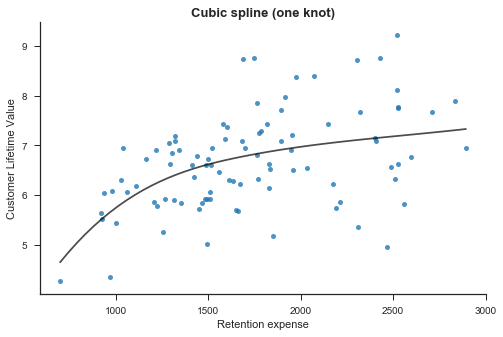

In [17]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Ret_Expense'], y_train,  scatter_kws = {'s': 25}, fit_reg=False, color=blue)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_xlabel('Retention expense')
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Cubic spline (one knot)', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

The next cell repeats all these steps for a linear spline with one knot. You should experiment by changing the first two lines to try different models (say, by adding more knots and/or changing the polynomial degree) and trying different predictors.

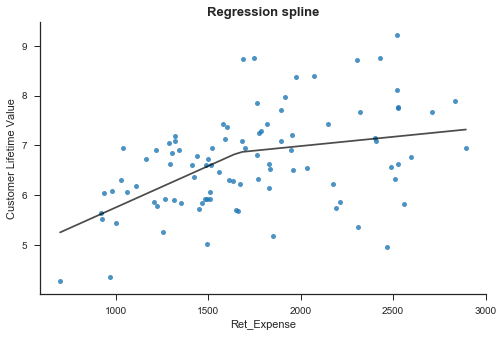

In [18]:
predictor = 'Ret_Expense'
X = dmatrix('bs(variable, degree=1, df=2) - 1', {'variable': train[predictor]}, return_type='dataframe')

ols = LinearRegression()
ols.fit(X, y_train)

a=train[predictor].min()
b=train[predictor].max()
x=np.linspace(a, b)

X_predict = build_design_matrices([X.design_info], {'variable': x})[0] # remember that X is our original design matrix
y_fitted=ols.predict(X_predict)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False, color=blue)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Regression spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

## Natural Cubic Splines

Estimating a natural cubic spline requires only a minor modification in the code.

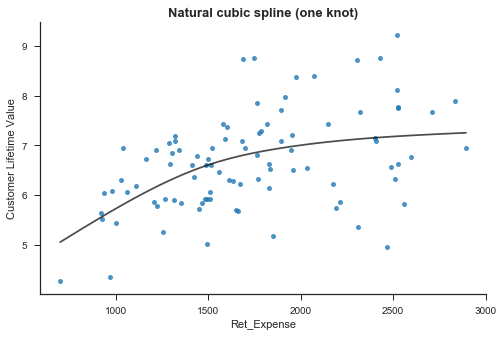

In [19]:
predictor = 'Ret_Expense'
X = dmatrix('cr(variable, df=4) - 1', {'variable': train[predictor]}, return_type='dataframe')

ols = LinearRegression()
ols.fit(X, y_train)

a=train[predictor].min()
b=train[predictor].max()
x=np.linspace(a, b)

X_predict = build_design_matrices([X.design_info], {'variable': x})[0] # remember that X is our original design matrix
y_fitted=ols.predict(X_predict)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False, color=blue)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Natural cubic spline (one knot)', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

## Generalised Additive Model

Building a generalised additive model from regression splines requires customised code. The <TT>statlearning</TT> module contains a function <TT>GAM_splines</TT> that takes all the predictors, a list identifying a subset of predictors for which we want to use natural splines, and the degrees of freedom for each natural spline, and then builds the corresponding design matrices for the training and test sets. 

In [20]:
from statlearning import GAM_splines

In [21]:
# The choices here are intuitive based on the EDA plots, ideally we should use cross validation

nonlinear=['Ret_Expense','Acq_Expense','Frequency','Employees']  # predictors not included here are assumed to be linear
dfs=[4,3,3,4] # the minimum DF is three for this to work

X_train_gam, X_test_gam = GAM_splines(X_train, X_test, nonlinear, dfs)

## Model Evaluation

Estimating the GAM is straightforward once we build the design matrices (we just apply the linear regression method).

The test results show that accounting for nonlinear effects leads to substantial improvements in predictive accuracy relative to the basic linear regression. 

In [22]:
# Fitting the two models

from sklearn.metrics import mean_squared_error, r2_score

ols = LinearRegression()
ols.fit(X_train, y_train)

gam = LinearRegression()
gam.fit(X_train_gam, y_train)


columns=['Test RMSE', 'Test R2']
rows=['OLS', 'GAM']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

# Linear regression
y_pred=ols.predict(X_test)
results.iloc[0,0] = np.sqrt(mean_squared_error(y_test, y_pred))
results.iloc[0,1] = r2_score(y_test, y_pred)


# Generalised additive model
y_pred=gam.predict(X_test_gam)
results.iloc[1,0] = np.sqrt(mean_squared_error(y_test, y_pred))
results.iloc[1,1] = r2_score(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2
OLS,0.539,0.661
GAM,0.420,0.795


When you write a report for the group project assignment, you may want to transfer the the results table (such as the one above) into a report.  The best way to do it is as follows.

In [23]:
results.to_excel('res.xlsx')

This saves the data frame <TT>results</TT> to an excel file, from which it can easily be transfered into the report in a nice format.


## Exercise

If you are looking for something more challenging: in the setting of Tutorial 8 (Classification Methods for the Customer Acquisition data), build a logistic regression model based on regression splines and investigate whether it leads to improved accuracy on the test data. 